In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
#classification
from sklearn.neighbors import KNeighborsClassifier #k-plus proches voisins
from sklearn_extra.cluster import KMedoids
import numpy as np
import pandas as pd

#Partitionnement
from sklearn.cluster import AgglomerativeClustering #Regroupement hiérarchique (Partitionnement binaire)
#from pyclustering.cluster.kmedoids import kmedoids
import kmedoids

#réduction de dimensionnalité
from sklearn.decomposition import KernelPCA #ce n'est pas PCoA mais on peut l'utiliser pour que le résultat soit le même
from sklearn.manifold import Isomap

Pour commencer le projet, nous allons créer une baseline pour MNIST en faisant la distance euclidienne pour tous les algorithmes que le projet nous indique. Donc nous le ferons pour:
● k-medoïde
● Partition binaire (Regroupement hiérarchique)
● PCoA (c'est un cas particulier de MDS)
● Isomap
● KNN (k-plus proches voisins)

Nous allons aussi importer MNIST et ADULT

In [3]:
from sklearn.preprocessing import StandardScaler, normalize
# https://notebook.community/francesco-mannella/neunet-basics/course/mnist
# import the mnist class
from mnist import MNIST

# init with the 'data' dir
mndata = MNIST('.\data')

# Load data
(train_X, train_y) = mndata.load_training()
data_train = pd.DataFrame(train_X)
#train_X = np.asarray(train_X)
#train_y = np.asarray(train_y)
(test_X, test_y) = mndata.load_testing()
data_test = pd.DataFrame(test_X)
#test_X = np.asarray(test_X)
#test_y = np.asarray(test_y)

print('X_train: ' + str(np.shape(train_X)))
print('Y_train: ' + str(np.shape(train_y)))
print('X_test:  '  + str(np.shape(test_X)))
print('Y_test:  '  + str(np.shape(test_y)))

# Standardizing the data (preprocessing)
scaler = StandardScaler()
X_std_train = scaler.fit_transform(train_X)

# Normalizing the data so that the data approximately
# follows a Gaussian distribution
X_normalized_train = normalize(X_std_train)

# Converting the numpy array into a pandas DataFrame
X_normalized_train = pd.DataFrame(X_normalized_train)


X_std_test = scaler.fit_transform(test_X)

# Normalizing the data so that the data approximately
# follows a Gaussian distribution
X_normalized_test = normalize(X_std_test)

# Converting the numpy array into a pandas DataFrame
X_normalized_test = pd.DataFrame(X_normalized_test)

# The number of pixels per side of all images
img_side = 28

# Each input is a raw vector.
# The number of units of the network
# corresponds to the number of input elements
n_mnist_pixels = img_side*img_side

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


Ici on vérifie que le dataset à bien téléchargé.

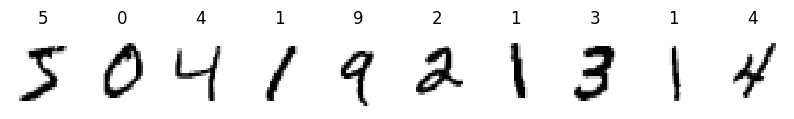

In [4]:
%matplotlib inline
from pylab import *

# Define the number of samples to take
num_samples = 10

# create a figure where we will store all samples
figure(figsize=(10,1))

# Iterate over samples indices
for sample in range(num_samples) :

    # The image corresponding to the 'sample' index
    img = train_X[sample]

    # The label of the image
    label = train_y[sample]

    # The image is stored as a rolled vector,
    # we have to roll it back in a matrix
    aimg = array(img).reshape(img_side, img_side)

    # Open a subplot for each sample
    subplot(1, num_samples, sample+1)

    # The corresponding digit is the title of the plot
    title(label)

    # We use imshow to plot the matrix of pixels
    imshow(aimg, interpolation = 'none',
        aspect = 'auto', cmap = cm.binary)
    axis("off")

show()

Ici nous ferons l'algorithme de k-medoïde avec la distance euclidienne pour MNIST

In [ ]:
# # https://medium.com/@ali.soleymani.co/beyond-scikit-learn-is-it-time-to-retire-k-means-and-use-this-method-instead-b8eb9ca9079a
# kmedo = KMedoids(n_clusters = 9, random_state=1)
# kmedo.fit(mndata.train_images, mndata.train_labels)
# # Doing predictions on the test set
# y_hat = kmedo.predict(mndata.test_images)
# acc = accuracy_score(mndata.test_labels, y_hat)
# print(acc)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from time import time


def bench_k_medoids(kmedoids, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmedoids).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [7]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html?fbclid=IwAR2CjekTcfhnp19Txryk2u5c2w2Zoa9O1kEBR710Bcg8kPNuCXQWj0-_zm8
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from time import time
from sklearn import metrics
from pyclustering.utils import distance_metric, type_metric
from pyclustering.cluster import cluster_visualizer

# Reduction of dimensionality
# This step is necessary, because k-medoids is just like kmeans and the algorithm doesn't scale very well to high dimensions
pca = PCA(n_components = 2)
# Training data set
X_principal = pca.fit_transform(X_std_train)
# Distance matrix with euclidean distance
diss = euclidean_distances(X_principal)


start = time()
fp = kmedoids.fasterpam(diss, medoids=10, max_iter=100)

print("FasterPAM took: %.2f ms" % ((time() - start)*1000))
print("Loss with FasterPAM:", fp.loss)
homo = metrics.homogeneity_score(labels_true=train_y, labels_pred=fp.labels)
compl = metrics.completeness_score(labels_true=train_y, labels_pred=fp.labels)
v_meas = metrics.v_measure_score(labels_true=train_y, labels_pred=fp.labels)
ARI = metrics.adjusted_rand_score(labels_true=train_y, labels_pred=fp.labels)
AMI = metrics.adjusted_mutual_info_score(labels_true=train_y, labels_pred=fp.labels)
silhouette = metrics.silhouette_score(X_principal,train_y, metric='euclidean', sample_size=np.shape(X_principal)[0])

print(82 * "_")
print("\ttime\thomo\tcompl\tv_meas\tARI\tAMI\tsilhouette")
print(f"{(time() - start)*1000} ms {homo} {compl} {v_meas} {ARI} {AMI} {silhouette}")
print(82 * "_")

start = time()
pam = kmedoids.pam(diss, medoids=10, max_iter=100)
homo = metrics.homogeneity_score(labels_true=train_y, labels_pred=pam.labels)
compl = metrics.completeness_score(labels_true=train_y, labels_pred=pam.labels)
v_meas = metrics.v_measure_score(labels_true=train_y, labels_pred=pam.labels)
ARI = metrics.adjusted_rand_score(labels_true=train_y, labels_pred=pam.labels)
AMI = metrics.adjusted_mutual_info_score(labels_true=train_y, labels_pred=pam.labels)
silhouette = metrics.silhouette_score(X_principal,train_y, metric='euclidean', sample_size=np.shape(X_principal)[0])
print("Loss with PAM:", pam.loss)
print("PAM took: %.2f ms" % ((time() - start)*1000))
print(82 * "_")
print("\ttime\thomo\tcompl\tv_meas\tARI\tAMI\tsilhouette")
print(f"{(time() - start)*1000} ms {homo} {compl} {v_meas} {ARI} {AMI} {silhouette}")
print(82 * "_")


# print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
#
#
# kmeans = kmedoids(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
# bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)
#
# kmeans = kmedoids(init="random", n_clusters=n_digits, n_init=4, random_state=0)
# bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)
#
# pca = PCA(n_components=n_digits).fit(data)
# kmeans = kmedoids(init=pca.components_, n_clusters=n_digits, n_init=1)
# bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)
#
# print(82 * "_")










# initial_medoids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# # create Minkowski distance metric with degree equals to '2'
# metric = distance_metric(type_metric.MINKOWSKI, degree=2)
# # create K-Medoids algorithm with specific distance metric
# medo = kmedoids(X_std_train, initial_medoids, metric=metric)
#
# # https://pyclustering.github.io/docs/0.9.0/html/d0/dd3/classpyclustering_1_1cluster_1_1kmedoids_1_1kmedoids.html
# # https://stackoverflow.com/questions/55335941/how-do-i-use-pyclustering-to-implement-kmedoids
#
# # Run cluster analysis and obtain results.
# medo.process()
# clusters_medo = medo.get_clusters()
# centers = medo.get_medoids()
# # Show allocated clusters.
# print(clusters_medo)
# # Display clusters.
# visualizer = cluster_visualizer()
# visualizer.append_clusters(clusters_medo, sample)
# visualizer.show()

FasterPAM took: 620091.27 ms
Loss with FasterPAM: 157720.71169210118
__________________________________________________________________________________
	time	homo	compl	v_meas	ARI	AMI	silhouette
<built-in function time> 0.2175392255694645 0.22344790705650058 0.22045398180548528 0.1427258921711257 0.22022209305399262 -0.06700980051294886
__________________________________________________________________________________
Loss with PAM: 156763.14600763292
PAM took: 25876414.70 ms
__________________________________________________________________________________
	time	homo	compl	v_meas	ARI	AMI	silhouette
<built-in function time> 0.2130057716038777 0.21788717198666302 0.21541882215508537 0.14129003332350049 0.21518591439614446 -0.06700980051294887
__________________________________________________________________________________


Ici nous ferons la partition binaire avec la distance euclidienne pour MNIST

In [4]:
# Prédictions en faisant la moyenne
def agglomerative_clustering_predict(agglomerative_clustering, X):
    average = list()
    ith_clusters = list()
    for i in range(agglomerative_clustering.n_clusters):
        # On fouille dans les train_X pour tous les labels i
        for j in range(len(agglomerative_clustering.labels_)):
            if agglomerative_clustering.labels_[j]==i:
                ith_clusters.append(X.iloc[j])
        average.append(np.array(ith_clusters).mean(axis=1))
    # np.stack makes this error: all input arrays must have the same shape
    return np.argmin(np.stack(average), axis=0)

In [4]:
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.metrics.cluster import v_measure_score

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# https://www.projectpro.io/recipes/do-agglomerative-clustering-in-python
# https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

# pca = PCA(n_components = 2)
# # Training data set
# X_principal = pca.fit_transform(X_std_train)
# X_principal = pd.DataFrame(X_principal)
# print(X_principal)
#X_principal.columns = ['P1', 'P2']

# # Testing data set
# X_secondary = pca.fit_transform(X_normalized_test)
# X_secondary = pd.DataFrame(X_secondary)
# X_secondary.columns = ['P1', 'P2']

# Dendogram requires normalized data, which is bad for mnist
# plt.figure(figsize =(8, 8))
# plt.title('Visualising the data')
# Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward')))

ac10 = AgglomerativeClustering(n_clusters = 10, affinity='euclidean')
labels = pd.DataFrame(ac10.fit_predict(X_std_train))
#acc = accuracy_score(y_true=train_y, y_pred=labels.iloc[:, 0])
vscore = v_measure_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])

print(f"V-measure score for agglomerative clustering with 10 clusters: {vscore}")
# V-measure score for agglomerative clustering with 10 clusters: 0.5844426454187285




# predictions = agglomerative_clustering_predict(ac2, X_principal)
# # Visualizing the clustering
# plt.figure(figsize =(6, 6))
# plt.title("10 clusters")
# plt.scatter(X_principal['P1'], X_principal['P2'],
#            c = predictions, cmap ='rainbow')
# plt.show()

# ac2 = AgglomerativeClustering(n_clusters = 2, affinity='euclidean')
# labels = pd.DataFrame(ac10.fit_predict(X_std_train))
# #acc = accuracy_score(y_true=train_y, y_pred=labels.iloc[:, 0])
# vscore = v_measure_score(labels_true=train_y, labels_pred=labels.iloc[:, 0])
# print(f"V-measure score for agglomerative clustering with 2 clusters: {vscore}")

# # Visualizing the clustering
# plt.figure(figsize =(6, 6))
# plt.title("2 clusters")
# plt.scatter(X_principal['P1'], X_principal['P2'],
#            c = predictions, cmap ='rainbow')
# plt.show()


# # Creating the agglomerative model
# agglo = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='average')
# # Fitting the model with the standardized data
# model = agglo.fit(X_std_train)
# # Predictions
# clusters = pd.DataFrame(model.fit_predict(X_std_test))
# clusters_agglo = model.fit_predict(X_std_test)
# acc = accuracy_score(y_true=test_y, y_pred=clusters_agglo)
#
# print(f"Accuracy for agglomerative clustering: {acc}")
# # data["Cluster"] = clusters

V-measure score for agglomerative clustering with 10 clusters: 0.5844426454187285


Ici nous ferons le PCoA avec la distance euclidienne pour MNIST

In [ ]:
pcoa = KernelPCA(n_components=1, kernel='precomputed')
pcoa_circle = pcoa.fit_transform(-.5*train_X**2) #-.5*D**2 est crucial!!!
pcoa_infinity = pcoa.transform(-.5*infinity_circle_cosine_dissimilarity**2) #-.5*D**2 est crucial!!!

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
ax.set_title('Cosine PCoA sur circle')
ax.scatter(pcoa_circle, np.zeros_like(pcoa_circle), c=theta);

ax = fig.add_subplot(212)
ax.set_title('Cosine PCoA sur infinity')
ax.scatter(pcoa_infinity, np.zeros_like(pcoa_infinity), c=theta2);

Ici nous ferons le KNN avec la distance euclidienne pour MNIST

In [21]:
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2, algorithm='auto')
knn.fit(train_X, train_y)

predictions = knn.predict(test_X)

acc = accuracy_score(y_true=test_y, y_pred=predictions)
print(f"Accuracy for KNN algorithm: {acc}")
# fig = plt.figure(figsize=(12, 6))
# circle_ax = fig.add_subplot(121)
# infinity_ax = fig.add_subplot(122)
# circle_ax.set_title('Cosine 2-plus proches voisins sur circle')
# infinity_ax.set_title('Cosine 2-plus proches voisins sur infinity')
#
# for i in range(4):
#     circle_cluster = circle[np.where(knn_circle == i)[0]]
#     circle_ax.scatter(circle_cluster[:, 0], circle_cluster[:, 1])
#
#     infinity_cluster = infinity[np.where(knn_infinity == i)[0]]
#     infinity_ax.scatter(infinity_cluster[:, 0], infinity_cluster[:, 1])

Accuracy for KNN algorithm: 0.9688


Ici nous ferons l'Isomap avec la distance euclidienne pour MNIST

D:\School Books\Session 5\IFT 3700\IFT-3700_TPs\Devoir 1\Devoir1\lib\site-packages\sklearn\manifold\_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 37 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\School Books\Session 5\IFT 3700\IFT-3700_TPs\Devoir 1\Devoir1\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\School Books\Session 5\IFT 3700\IFT-3700_TPs\Devoir 1\Devoir1\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\School Books\Session 5\IFT 3700\IFT-3700_TPs\Devoir 1\Devoir1\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning:

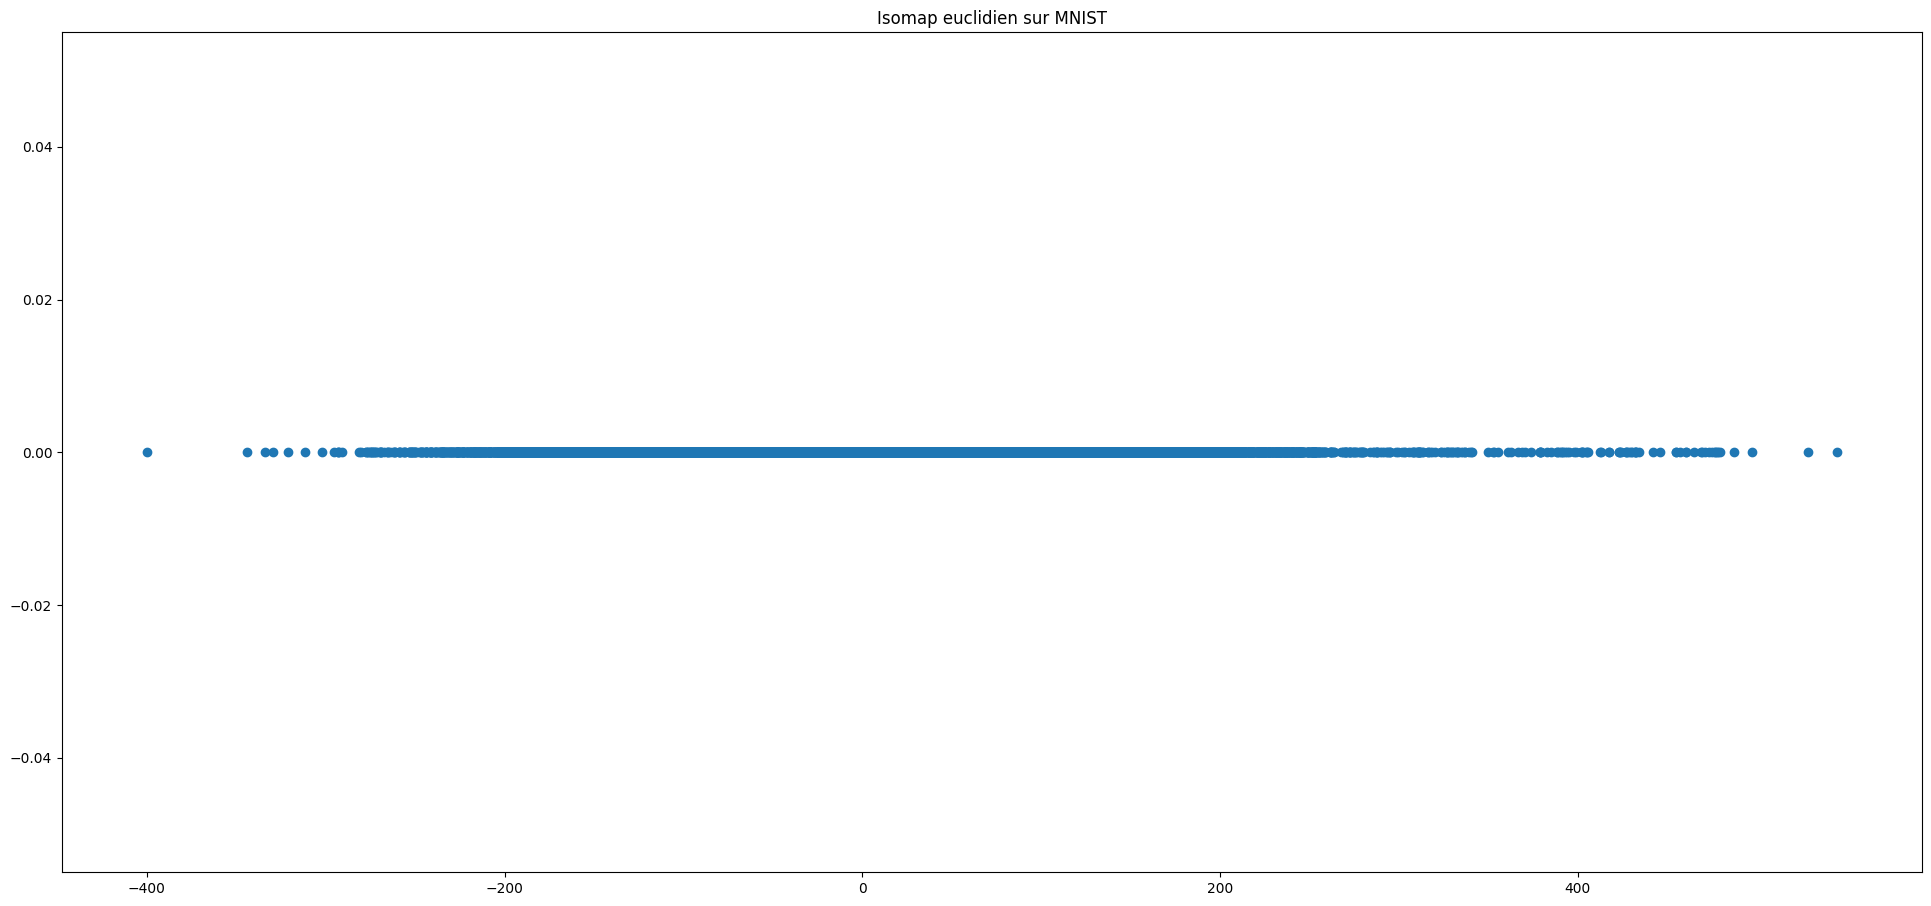

In [5]:
isomap = Isomap(n_components=2, n_neighbors=2, metric='minkowski', p=2)
isomap_model = isomap.fit_transform(X_std_train)

fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(211)
ax.set_title('Isomap euclidien sur MNIST')
ax.scatter(isomap_model, np.zeros_like(isomap_model))
# UserWarning: The number of connected components of the neighbors graph is 37 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
# self._fit_transform(X)